# <center>Classification Project</center>

Prepared by:
- Ayetijhya Desmukhya
- Assyl Salah

### Overview

`job_change` for classification

Our task is to apply various ML algorithms (see the rules below) to build a model explaining whether a particular person is willing to change job based on the training sample and generate predictions for all observations from the test sample.

The dataset includes 12427 observations in the training sample and 3308 in the test sample and the following columns:
- `id` – unique observation identifier
- `gender` – gender of a person
- `age` – age of a person in years
- `education` – highest formal education level of a person attained so far
- `field_of_studies` – field of studies of a person
- `is_studying` – information whether a person is currently studying
- `county` – county code in which the person currently lives and works
- `relative_wage` – relative wage in the county (as percentage of country average)
- `years_since_job_change` – years since a person last changed the job
- `years_of_experience` – total number of years of professional experience of a person
- `hours_of_training` – total number of training hours completed by a person
- `is_certified` – does a person have any formal certificate of completed trainings
- `size_of_company` – size of a company in which a person currently works
- `typs_of_company` – type of a company in which a person currently works
- `willing_to_change_job` – is a person willing to change job (outcome variable, only in the training sample)

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import chi2_contingency, fisher_exact

#Scaling
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 500)
np.random.seed(2002)

### Dataset Preparation

In [2]:
# Load train dataset
job_change_data_train = pd.read_csv('data\job_change_train.csv')
job_change_data_train.head()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,1,Male,22,higher_BSc,science,no,county_118,162.84,1,2,18,1,<10,private_company,No
1,2,Male,27,higher_BSc,science,no,county_028,151.34,1,6,24,1,50-99,private_company,No
2,3,Male,38,higher_BSc,science,no,county_031,114.17,1,13,96,1,50-99,startup_with_funding,No
3,4,Unknown,47,higher_BSc,science,no,county_080,123.55,>4,>20,36,1,100-500,private_company,No
4,5,Male,28,higher_BSc,science,no,county_118,162.84,1,5,106,1,1000-4999,private_company,No


In [3]:
# Load test dataset
job_change_data_test = pd.read_csv('data\job_change_test.csv')
job_change_data_test.head()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company
0,12428,Male,32,higher_BSc,science,no,county_053,166.20,4,9,22,1,10000+,private_company
1,12429,Male,33,higher_BSc,science,no,county_005,153.10,2,9,152,1,50-99,private_company
2,12430,Male,36,higher_BSc,science,no,county_059,110.45,>4,17,23,0,10000+,private_company
3,12431,Male,30,higher_MSc,science,no,county_118,162.84,1,10,21,1,10000+,private_company
4,12432,Male,33,higher_MSc,science,no,county_110,163.90,2,10,15,1,500-999,private_company


### Data Inspection

In [4]:
# Check for data information
job_change_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12427 non-null  int64  
 1   gender                  12427 non-null  object 
 2   age                     12427 non-null  int64  
 3   education               12427 non-null  object 
 4   field_of_studies        12427 non-null  object 
 5   is_studying             12427 non-null  object 
 6   county                  12427 non-null  object 
 7   relative_wage           12427 non-null  float64
 8   years_since_job_change  12427 non-null  object 
 9   years_of_experience     12427 non-null  object 
 10  hours_of_training       12427 non-null  int64  
 11  is_certified            12427 non-null  int64  
 12  size_of_company         12427 non-null  object 
 13  type_of_company         12427 non-null  object 
 14  willing_to_change_job   12427 non-null

In [5]:
# Checking for missing data - no missing data found
job_change_data_train.isnull().sum()

id                        0
gender                    0
age                       0
education                 0
field_of_studies          0
is_studying               0
county                    0
relative_wage             0
years_since_job_change    0
years_of_experience       0
hours_of_training         0
is_certified              0
size_of_company           0
type_of_company           0
willing_to_change_job     0
dtype: int64

In [6]:
# Check if data is duplicated
job_change_data_train.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
12422    False
12423    False
12424    False
12425    False
12426    False
Length: 12427, dtype: bool

In [7]:
# Categorical columns
cat_col = [col for col in job_change_data_train.columns if job_change_data_train[col].dtype == 'object']
print('Categorical columns :',cat_col)
# Numerical columns
num_col = [col for col in job_change_data_train.columns if job_change_data_train[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['gender', 'education', 'field_of_studies', 'is_studying', 'county', 'years_since_job_change', 'years_of_experience', 'size_of_company', 'type_of_company', 'willing_to_change_job']
Numerical columns : ['id', 'age', 'relative_wage', 'hours_of_training', 'is_certified']


In [8]:
# Check possible values for categorical columns
unique_values_dict = {}
    
for col in cat_col:
    unique_values_dict[col] = job_change_data_train[col].unique().tolist()

unique_values_dict

{'gender': ['Male', 'Unknown', 'Female', 'Other'],
 'education': ['higher_BSc',
  'secondary',
  'higher_MSc',
  'Phd',
  'primary',
  'no_information'],
 'field_of_studies': ['science',
  'no_information',
  'other',
  'humanities',
  'business',
  'arts'],
 'is_studying': ['no', 'full_time', 'part_time', 'no_information'],
 'county': ['county_118',
  'county_028',
  'county_031',
  'county_080',
  'county_059',
  'county_117',
  'county_074',
  'county_049',
  'county_040',
  'county_018',
  'county_110',
  'county_022',
  'county_025',
  'county_075',
  'county_119',
  'county_092',
  'county_041',
  'county_121',
  'county_108',
  'county_053',
  'county_006',
  'county_020',
  'county_077',
  'county_019',
  'county_042',
  'county_081',
  'county_038',
  'county_029',
  'county_112',
  'county_086',
  'county_001',
  'county_068',
  'county_021',
  'county_116',
  'county_013',
  'county_093',
  'county_024',
  'county_102',
  'county_099',
  'county_058',
  'county_062',
  'coun

### Data Adjustment

In [9]:
# Changing all categorical columns into numerical ones as they might be significant features
# Define mapping dictionaries
mappings = {
    'gender': {'Unknown': -1, 'Male': 0, 'Female': 1, 'Other': 2},
    'education': {'no_information': -1, 'primary': 0, 'secondary': 1, 'higher_BSc': 2, 'higher_MSc': 3, 'Phd': 4},
    'field_of_studies': {'no_information': -1, 'science': 0, 'business': 1, 'humanities': 2, 'arts': 3, 'other': 4},
    'is_studying': {'no_information': -1, 'no': 0, 'part_time': 1, 'full_time': 2},
    'county': {f'county_{i:03d}': i for i in range(1, len(job_change_data_train['county'].unique())+1)},
    'years_since_job_change': {'unknown': -1, 'never_changed': 0, **{str(i): i for i in range(1, 5)}, '>4': 5},
    'years_of_experience': {'unknown': -1, '<1': 0, **{str(i): i for i in range(1, 21)}, '>20': 21},
    'size_of_company': {'unknown': -1, '<10': 0, '<10': 0, '10-49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7},
    'type_of_company': {'no_information': -1, 'startup_wo_funding': 0, 'startup_with_funding': 1, 'private_company': 2, 'NGO': 3, 'public_sector': 4, 'other': 5},
    'willing_to_change_job': {'No': 0, 'Yes': 1}
}

# Apply mappings
for column, mapping in mappings.items():
    job_change_data_train[column] = job_change_data_train[column].map(mapping)
    if column != 'willing_to_change_job':
        job_change_data_test[column] = job_change_data_test[column].map(mapping)


### Initial Descriptive Analysis of Data

In [10]:
# Check statistics
round(job_change_data_train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
id,12427.0,6214.00,3587.51,1.0,3107.50,6214.00,9320.50,12427.00
gender,12427.0,-0.15,0.57,-1.0,0.00,0.00,0.00,2.00
age,12427.0,32.84,8.16,20.0,26.00,31.00,38.00,50.00
education,12427.0,2.06,0.83,-1.0,2.00,2.00,2.00,4.00
field_of_studies,12427.0,0.11,0.96,-1.0,0.00,0.00,0.00,4.00
is_studying,12427.0,0.43,0.82,-1.0,0.00,0.00,1.00,2.00
county,12427.0,78.66,35.56,1.0,59.00,75.00,118.00,123.00
relative_wage,12427.0,146.56,21.96,79.3,130.63,159.83,162.84,167.97
years_since_job_change,12427.0,1.94,1.72,-1.0,1.00,1.00,3.00,5.00
years_of_experience,12427.0,10.08,6.82,-1.0,4.00,9.00,16.00,21.00


### Target Variable Analysis

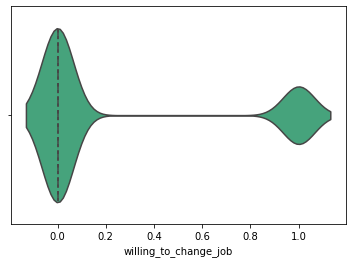

In [11]:
# Target Variable Distribution
sns.violinplot(x=job_change_data_train['willing_to_change_job'], inner="quartile", color="#36B37E");

In [12]:
job_change_data_train.groupby("education")["willing_to_change_job"].describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
-1,295.0,0.216949,0.412868,0.0,0.0,0.0,0.0,1.0
0,196.0,0.163265,0.370554,0.0,0.0,0.0,0.0,1.0
1,1320.0,0.184091,0.387705,0.0,0.0,0.0,0.0,1.0
2,7528.0,0.278826,0.448451,0.0,0.0,0.0,1.0,1.0
3,2831.0,0.218297,0.413163,0.0,0.0,0.0,0.0,1.0
4,257.0,0.120623,0.326324,0.0,0.0,0.0,0.0,1.0


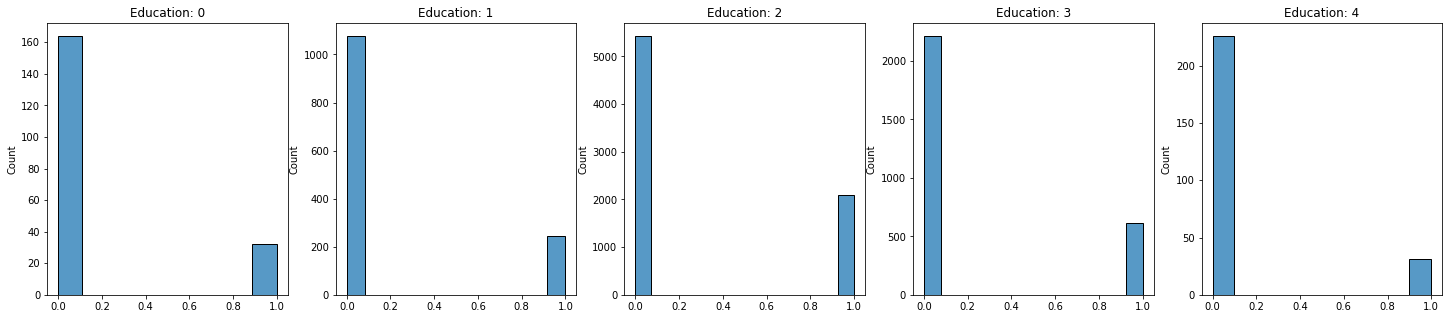

In [13]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
for i, ax in zip(range(0, 6), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.education == i].willing_to_change_job, ax=ax).set(
        title=f"Education: {i}", xlabel=""
    )
plt.show()

In [14]:
job_change_data_train.groupby("size_of_company")["willing_to_change_job"].describe()

,count,mean,std,min,25%,50%,75%,max
size_of_company,,,,,,,,
-1,3850.0,0.402857,0.490536,0.0,0.0,0.0,1.0,1.0
0,854.0,0.154567,0.361703,0.0,0.0,0.0,0.0,1.0
1,923.0,0.232936,0.422931,0.0,0.0,0.0,0.0,1.0
2,2008.0,0.178287,0.382849,0.0,0.0,0.0,0.0,1.0
3,1644.0,0.159976,0.366695,0.0,0.0,0.0,0.0,1.0
4,582.0,0.175258,0.380514,0.0,0.0,0.0,0.0,1.0
5,875.0,0.154286,0.361429,0.0,0.0,0.0,0.0,1.0
6,362.0,0.190608,0.393324,0.0,0.0,0.0,0.0,1.0
7,1329.0,0.197141,0.397989,0.0,0.0,0.0,0.0,1.0


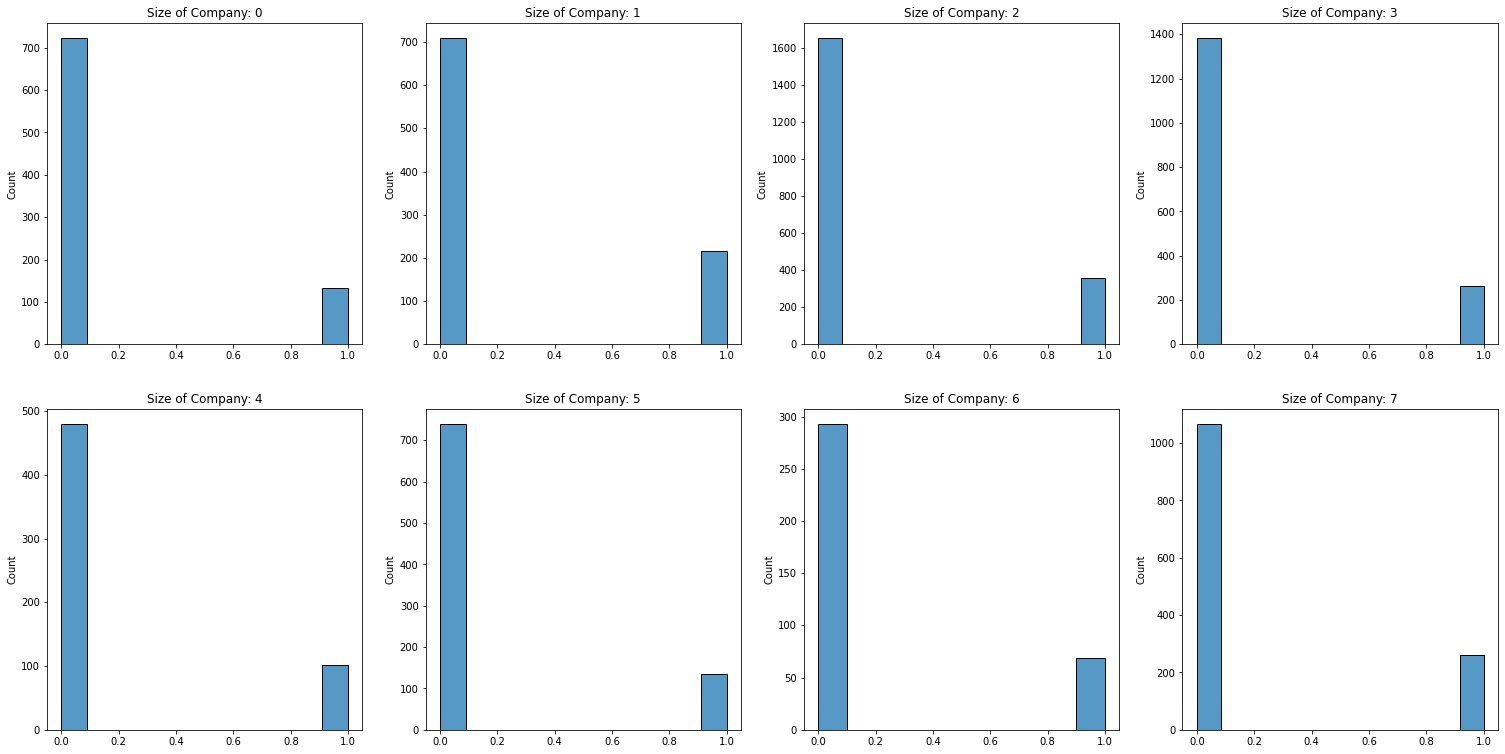

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(26,13))
for i, ax in zip(range(0, 8), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.size_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Size of Company: {i}", xlabel=""
    )
plt.show()

In [16]:
job_change_data_train.groupby("type_of_company")["willing_to_change_job"].describe()

,count,mean,std,min,25%,50%,75%,max
type_of_company,,,,,,,,
-1,3995.0,0.386984,0.487121,0.0,0.0,0.0,1.0,1.0
0,377.0,0.241379,0.428488,0.0,0.0,0.0,0.0,1.0
1,655.0,0.143511,0.350862,0.0,0.0,0.0,0.0,1.0
2,6372.0,0.178280,0.382778,0.0,0.0,0.0,0.0,1.0
3,330.0,0.200000,0.400607,0.0,0.0,0.0,0.0,1.0
4,613.0,0.220228,0.414739,0.0,0.0,0.0,0.0,1.0
5,85.0,0.223529,0.419083,0.0,0.0,0.0,0.0,1.0


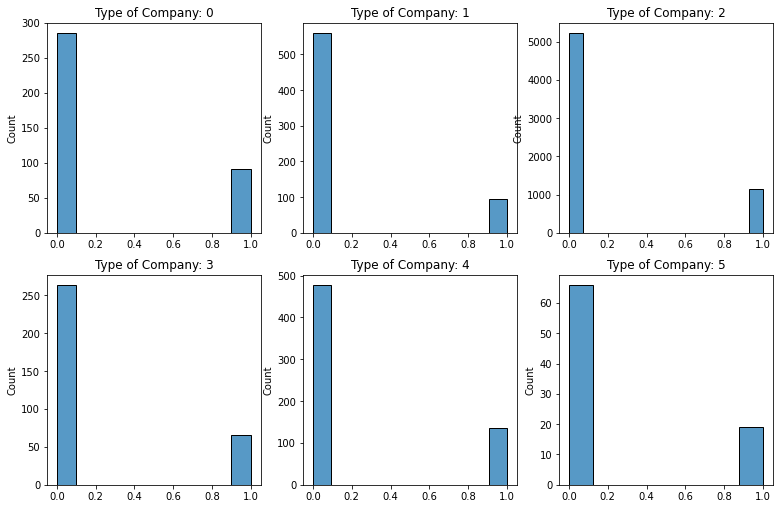

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13,8.5))
for i, ax in zip(range(0, 6), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.type_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Type of Company: {i}", xlabel=""
    )
plt.show()

In [18]:
job_change_data_train.groupby("is_certified")["willing_to_change_job"].describe()

,count,mean,std,min,25%,50%,75%,max
is_certified,,,,,,,,
0,3477.0,0.338798,0.473369,0.0,0.0,0.0,1.0,1.0
1,8950.0,0.213296,0.409658,0.0,0.0,0.0,0.0,1.0


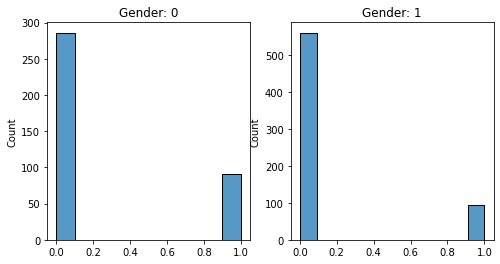

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
for i, ax in zip(range(0, 3), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.type_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Gender: {i}", xlabel=""
    )
plt.show()

In [36]:
# Identify categorical columns
categorical_columns = cat_col[:-1]

# Perform tests for all pairs of categorical columns
for col in categorical_columns:
    # Create contingency table
    print(col)
    contingency_table = pd.crosstab(job_change_data_train[col], job_change_data_train['willing_to_change_job'])
    print(contingency_table.shape)
    print(contingency_table)
    # Chi-square Test
    chi2_stat, p_val_chi2, _, _ = chi2_contingency(contingency_table)

    # Fisher's Exact Test
#     odds_ratio, p_val_fisher = fisher_exact(contingency_table)

    print(f"\nChi-square test between '{col}' and 'willing_to_change_job':")
    print("Chi-square test statistic:", chi2_stat)
    print("P-value:", p_val_chi2)

#     print(f"\nFisher's exact test between '{col}' and 'willing_to_change_job':")
#     print("Fisher's exact test odds ratio:", odds_ratio)
#     print("P-value:", p_val_fisher)


gender
(4, 2)
willing_to_change_job     0     1
gender                           
-1                     2051   912
 0                     6584  1931
 1                      619   207
 2                       86    37

Chi-square test between 'gender' and 'willing_to_change_job':
Chi-square test statistic: 79.14490474918692
P-value: 4.6821008962468794e-17
education
(6, 2)
willing_to_change_job     0     1
education                        
-1                      231    64
 0                      164    32
 1                     1077   243
 2                     5429  2099
 3                     2213   618
 4                      226    31

Chi-square test between 'education' and 'willing_to_change_job':
Chi-square test statistic: 111.95183527039569
P-value: 1.5845958904191632e-22
field_of_studies
(6, 2)
willing_to_change_job     0     1
field_of_studies                 
-1                     1486   349
 0                     6928  2452
 1                      157    56
 2             

### Correlation of the variables

In [22]:
job_change_data_train.corr()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
id,1.000000,-0.001818,0.007003,0.003171,-0.000650,0.008608,-0.004987,0.014861,-0.012721,0.005034,0.007514,-0.013275,-0.001686,-0.013559,-0.003361
gender,-0.001818,1.000000,0.091737,0.058934,0.071255,-0.064269,0.048285,0.153286,0.101847,0.104503,-0.000880,0.079346,0.042418,0.052459,-0.052978
age,0.007003,0.091737,1.000000,0.241462,0.098957,-0.299016,0.124948,0.320396,0.450490,0.960352,0.006598,0.307317,0.143034,0.129232,-0.162516
education,0.003171,0.058934,0.241462,1.000000,0.348692,-0.099981,0.014822,0.043287,0.195905,0.256996,-0.006606,0.233801,0.222653,0.211905,-0.001079
field_of_studies,-0.000650,0.071255,0.098957,0.348692,1.000000,-0.117293,0.087633,0.071152,0.102027,0.102584,-0.010201,0.103501,0.076175,0.085301,0.014121
is_studying,0.008608,-0.064269,-0.299016,-0.099981,-0.117293,1.000000,-0.071527,-0.141467,-0.216768,-0.313766,-0.003923,-0.357327,-0.184015,-0.146764,0.132514
county,-0.004987,0.048285,0.124948,0.014822,0.087633,-0.071527,1.000000,0.320507,0.083817,0.126211,-0.010114,0.016925,0.067353,0.051379,-0.053968
relative_wage,0.014861,0.153286,0.320396,0.043287,0.071152,-0.141467,0.320507,1.000000,0.205321,0.337170,-0.005362,0.064764,0.094709,0.091106,-0.344828
years_since_job_change,-0.012721,0.101847,0.450490,0.195905,0.102027,-0.216768,0.083817,0.205321,1.000000,0.476511,-0.005211,0.248136,0.201952,0.214549,-0.090597
years_of_experience,0.005034,0.104503,0.960352,0.256996,0.102584,-0.313766,0.126211,0.337170,0.476511,1.000000,0.003108,0.338573,0.158402,0.148443,-0.175241


In [23]:
hich column is imprtant for the target vatiable


SyntaxError: invalid syntax (<ipython-input-23-f1623de645b4>, line 1)

In [ ]:
sns.distplot(job_change_data_train['willing_to_change_job'], kde=False, 
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.ylabel("Count");

In [ ]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.25)
sns.heatmap(job_change_data_train.corr(), annot=True) 
plt.show()

#### Strong Positive Correlation
- Age and Years of Experience: `age` and `years_of_experience` are positively correlated with each other approximating to `0.96`. This indicates that older individuals tend to have more years of experience and may have spent more time since their last job change.

#### Positive Correlation
- Relative Wage with Age, Years of Experience, County: `relative_wage` shows a positive correlation with `age`, `years_of_experience`, and `county`. This suggests that individuals with higher relative wages tend to be older, have more experience, and come from more specific regions.
- While `age` and `county` show a weak positive correlation of `0.12`, indicating a slight tendency for older individuals to be associated with specific counties, `years_since_job_change` and `age` exhibit a stronger correlation of `0.45`, implying that older individuals tend to stay longer in their current jobs. Furthermore, `age` has moderate positive correlations with both `education (0.241462)` and `is_certified (0.31)`, suggesting that older individuals are more likely to possess higher education levels and certifications compared to their younger counterparts.
- A moderate positive correlation of `0.35` between `education` and `field_of_studies` suggests that individuals with advanced education levels often specialize in particular fields of study. Additionally, `years_since_job_change` shows a positive correlation of `0.2` with `education`, implying that those who have been in their current job longer typically possess higher educational qualifications. Furthermore, `years_of_experience` has a correlation of `0.26` with `education`, indicating that more experienced individuals tend to have higher levels of education. The `is_certified` variable correlates positively with Education at `0.23`, suggesting that certified individuals often have advanced educational backgrounds. Lastly, `size_of_company` and `type_of_company` show weak positive correlations of `0.22` and `0.21`, respectively, with `education`, hinting that individuals with higher educational qualifications might work for larger or specific types of companies.

#### Weak Correlation
- Identifiers like `id` are not informative for predictive modeling as they are unique for each record and don't provide any meaningful information about the target variable.
- The correlation values for `gender`, `hours_of_training`, `is_studying` indicates a very weak correlation with the target variable. This suggests that these features may not significantly influence the willingness to change jobs in the dataset.

In [ ]:
# Remove very weakly correlated columns 
columns_to_remove = ['id','gender', 'hours_of_training', 'is_studying']
job_change_data_train.drop(columns=columns_to_remove, inplace=True)
job_change_data_train

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(30, 30))
for i, ax in zip(job_change_data_train.columns, axes.flat):
    sns.histplot(x=job_change_data_train[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

In [ ]:
# Select only numerical columns for boxplot
numerical_columns = job_change_data_train.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(5, 5, i)  # Adjust subplot layout based on the number of columns
    plt.boxplot(job_change_data_train[column])  # Plot boxplot for each column
    plt.title(column)  # Set title as column name
    plt.grid(True)  # Add grid for better visualization

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

In [ ]:
from scipy.stats import zscore
import numpy as np

# Using z-score to rmove outliers
z_scores = zscore(job_change_data_train)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

job_change_data_train = job_change_data_train[filtered_entries]

In [ ]:
round(job_change_data_train.describe().T,2)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 
            'years_since_job_change', 'years_of_experience', 'is_certified', 
            'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(job_change_data_train[features], 
                                                      job_change_data_train[target], 
                                                      test_size=0.2, 
                                                      random_state=4)

# List of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_valid)
    
    # Calculate accuracy and balanced accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{name} Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("="*50)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 
            'years_since_job_change', 'years_of_experience', 'is_certified', 
            'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(job_change_data_train[features], 
                                                      job_change_data_train[target], 
                                                      test_size=0.2, 
                                                      random_state=4)

# List of classifiers
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier()
}

# Define the parameter grid for each classifier
param_grids = {
    "Gradient Boosting": {'n_estimators': [50, 100, 200, 30],'learning_rate': [0.01, 0.05, 0.1, 0.19], 'max_depth': [3, 5, 7]},
    "LightGBM": {'learning_rate': [0.008,0.099,0.0009,0.009,0.007,0.005], 'n_estimators': [275, 250,225]}
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Tuning {name}...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Predict on validation set with best parameters
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_valid)
    
    # Calculate accuracy and balanced accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{name} Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("="*50)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 'years_since_job_change', 
            'years_of_experience', 'is_certified', 'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Define Random Forest Classifier
clf = LGBMClassifier(random_state=123)

# Create learning curve
train_sizes, train_scores, valid_scores = learning_curve(clf, 
                                                         job_change_data_train[features], 
                                                         job_change_data_train[target], 
                                                         train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 
                                                         cv=5)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.3)
plt.plot(train_sizes, valid_mean, label='Validation score', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='red', alpha=0.3)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()
